In [1]:
import argparse
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch


from fireworks import LaunchPad
from jobflow import JobStore
from jobflow.managers.fireworks import flow_to_workflow
from maggma.stores.mongolike import MongoStore
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
import uuid

from botorch.models import SingleTaskGP, ModelListGP
from botorch import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

from common import seed_generator, configs

from common.utils import get_int, get_qe
from common import utils


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
def get_data_botorch(data_file, from_cloud = True):
    if from_cloud:
        df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
        #df = df.drop(labels=range(1, 600), axis=0)
        my_data = df.to_numpy()
        print(f"reading data log from google sheet: {GSPREAD_NAME}!")
    else:
        my_data = np.loadtxt(data_file, delimiter=',', skiprows=1)
        print(f"reading data log from local: {data_file}!")

    # features
    train_x = torch.from_numpy(my_data[:, :5])
    # labels
    train_y = torch.from_numpy(my_data[:, 5]).unsqueeze(-1)
    # best observation
    best_y = train_y.max().item()
    
    return train_x, train_y, best_y


def encode_inputs(x_arr, x_max = 34):
    '''encode simulation input to botorch'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0] = arr[0] + arr[1]
        if arr[0] + arr[1] == 0:
            x_arr[i, 1] = 0.5
        else:
            x_arr[i, 1] = arr[0] / (arr[0] + arr[1])
        x_arr[i, 2] = arr[2] + arr[3]
        if arr[2] + arr[3] == 0:
            x_arr[i, 3] = 0.5
        else:
            x_arr[i, 3] = arr[2] / (arr[2] + arr[3])
        x_arr[i, 4] = arr[4] / x_max


def decode_candidates(x_arr, x_max = 34):
    '''decode botorch recommendation candidates for simulation'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0], x_arr[i, 1] = arr[0] * arr[1], arr[0] * (1 - arr[1])
        x_arr[i, 2], x_arr[i, 3] = arr[2] * arr[3], arr[2] * (1 - arr[3])
        x_arr[i, 4] = arr[4] * x_max

def recommend(train_x, train_y, best_y, bounds, n_trails = 5):
    if isinstance(bounds, list):
        bounds = torch.tensor(bounds)
    elif torch.is_tensor(bounds):
        pass
    else:
        raise TypeError(f"expect bounds in a list or tensor. was given {type(bounds)}")
    
    single_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    # Expected Improvement acquisition function
    EI = qExpectedImprovement(model = single_model, best_f = best_y)
    # Upper Confidence Bound acquisition function
    UCB = UpperConfidenceBound(single_model, beta=100)
    
    # hyperparameters are super sensitive here
    candidates, _ = optimize_acqf(acq_function = UCB,
                                 bounds = bounds, 
                                 q = n_trails, 
                                 num_restarts = 20, 
                                 raw_samples = 512, 
                                # options = {'batch_limit': 5, "maxiter": 200}
                                 )
    
    return candidates

# Optimization analysis

In [138]:
# use this for data saved in cloud
from common import gcloud_utils
GSPREAD_CRED = './common/sustained-spark-354104-2f5a40769608.json'
GSPREAD_NAME = 'simulation_log.csv'
df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
#df.sort_values(by='VIS', ascending=False).head(10)

In [3]:
#  use this for local data
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
# DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test2.csv"
df = pd.read_csv(DATA_DEST)
#df_0p5 = pd.read_csv(DATA_DEST2)

In [116]:
id_start = 640
yb1_mean = round(np.mean(df[id_start:]['yb_1']),4)
yb1_std = round(np.std(df[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df[id_start:]['er_1']),4)
er1_std = round(np.std(df[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df[id_start:]['yb_2']),4)
yb2_std = round(np.std(df[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df[id_start:]['er_2']),4)
er2_std = round(np.std(df[id_start:]['er_2']),4)
radius_mean = round(np.mean(df[id_start:]['radius']),4)
radius_std = round(np.std(df[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')


yb_1: 0.7267+/-0.0008
er_1: 0.0039+/-0.0002
yb_2: 0.0+/-0.0
er_2: 0.0+/-0.0
radius: 22.1991+/-0.0065


In [104]:
round(np.mean(df[635:]['yb_1']),4)

3.9476

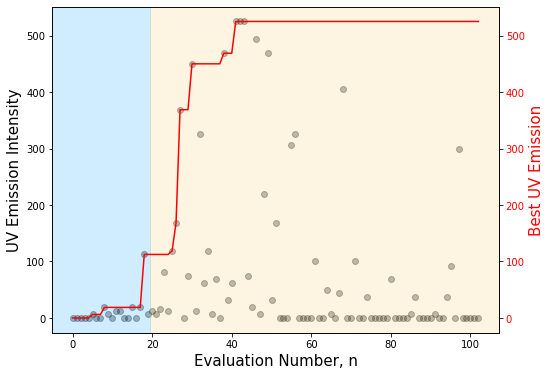

In [4]:
import matplotlib.pyplot as plt

# plot single result
evalued = len(df)
max_uv = []
y = df.UV
for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()
ax1.scatter(x, y, c='black', alpha = 0.3)
ax2.plot(x, max_uv, c='r', alpha = 1)

FontSize = 15
ax1.set_ylim(-max(y)*0.05,max(y)*1.05)
ax2.set_ylim(-max(y)*0.05,max(y)*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
# plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
# plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()

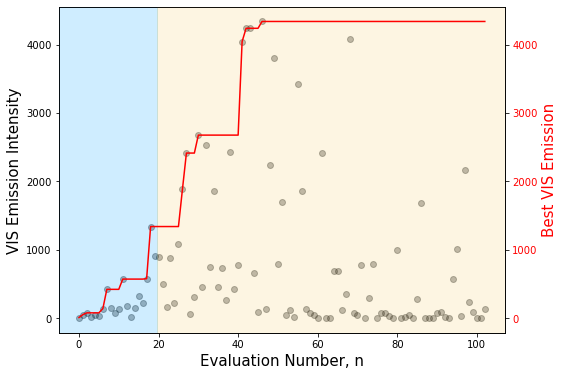

In [5]:
import matplotlib.pyplot as plt

# plot single result
evalued = len(df)
max_uv = []
y = df.VIS
for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].VIS.max())
x = range(len(max_uv))   

fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()
ax1.scatter(x, y, c='black', alpha = 0.3)
ax2.plot(x, max_uv, c='r', alpha = 1)

FontSize = 15
ax1.set_ylim(-max(y)*0.05,max(y)*1.05)
ax2.set_ylim(-max(y)*0.05,max(y)*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('VIS Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best VIS Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
# plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
# plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()

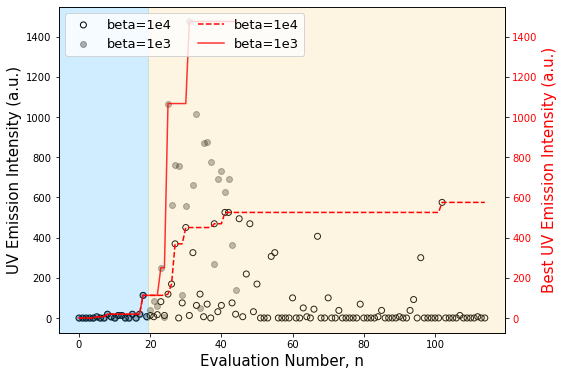

In [217]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=1e4')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='beta=1e4')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=1e3')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='beta=1e3')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


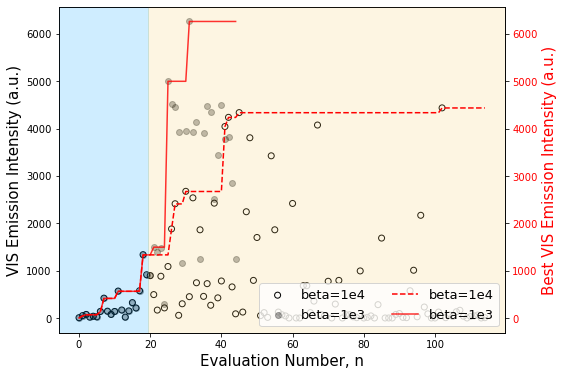

In [218]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.VIS

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.VIS

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].VIS.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].VIS.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=1e4')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='beta=1e4')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=1e3')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='beta=1e3')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('VIS Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best VIS Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


In [8]:
# Euclidean distance
def encode(arr, x_max = 34):
    x_arr = arr
    x_arr[0] = arr[0] + arr[1]
    if arr[0] + arr[1] == 0:
        x_arr[1] = 0.5
    else:
        x_arr[1] = arr[0] / (arr[0] + arr[1])
    x_arr[2] = arr[2] + arr[3]
    if arr[2] + arr[3] == 0:
        x_arr[3] = 0.5
    else:
        x_arr[3] = arr[2] / (arr[2] + arr[3])
    x_arr[4] = arr[4] / x_max
    return x_arr

def Euc_dist(X,Y):
    sum = 0
    for x, y in zip(X,Y):
        sum += (x-y)**2
    return np.sqrt(sum)
        
evalued1 = len(df)
distance_1 = []
for i in range(evalued1):
    temp = df.iloc[i].to_numpy()[:5].copy()
    temp = encode(temp)
    dist = Euc_dist(temp, best_init_1)
    distance_1.append(dist)

x_1 = range(len(df))
y = distance_1

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.4, marker='X',label='beta=100')
#ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Euclidean Distance', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([0,660])

# add best points
best_init = df.iloc[:619].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[620:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
plt.show()



NameError: name 'best_init_1' is not defined

In [142]:
df.iloc[best_rec-1]

yb_1               0.725410
er_1               0.004203
yb_2               0.000000
er_2               0.000000
radius            22.201403
UV              9049.999376
VIS             6137.499535
BLUE            1024.999923
GREEN           1037.499925
RED             1462.499873
TOTAL          16362.498870
ABSORPTION    116987.491600
qe                 0.022292
Name: 636, dtype: float64

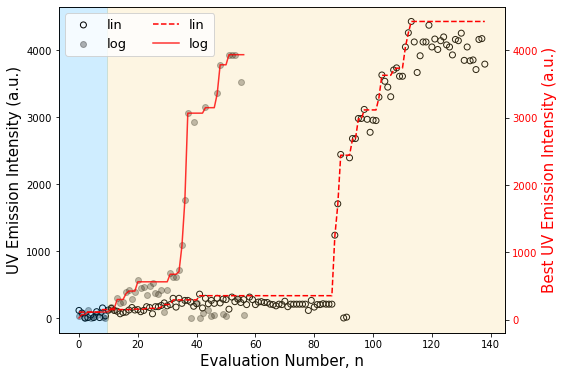

In [193]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_KS_10initial_linscale.csv"
DATA_DEST2 = "../saved_data/UV_log_KS_10initial_logscale.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='lin')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='lin')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='log')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='log')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


In [150]:
df_0p5.iloc[10:]

,yb_1,er_1,yb_2,er_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
10,0.703814,0.076095,0.060209,0.013141,29.0,1358.332990,4366.665542,499.999857,1624.999613,2041.666104,6224.998405,39191.656441,0.002339
11,0.000000,0.001000,0.000000,0.060209,5.0,0.000000,18.748910,0.000000,6.249919,12.498990,18.748910,106.197494,0.000311
12,0.703814,0.067688,0.042376,0.007318,29.0,1737.499704,5168.749166,718.749894,1681.249730,2424.999595,7293.748813,43893.742789,0.002820
13,0.703814,0.053557,0.033529,0.004582,29.0,1924.999644,5281.248982,749.999865,1693.749673,2487.499501,7549.998541,50443.739675,0.002984
14,0.626052,0.348637,0.016609,0.000000,5.0,12.499839,24.996540,0.000000,0.000000,12.496701,24.996540,6280.840291,0.000319
15,0.001000,0.000000,0.703814,0.000000,33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1118.710691,0.000000
16,0.001000,0.000000,0.001000,0.000000,33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,442.507732,0.000000


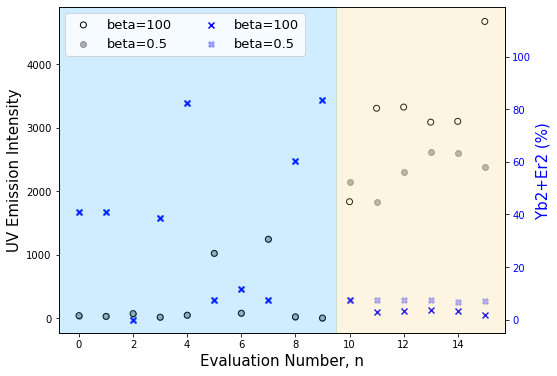

In [257]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
shell_sum = (df.yb_2+df.er_2)*100
shell_sum_2 = (df_0p5.yb_2+df_0p5.er_2)*100
y = df.UV
y_2 = df_0p5.UV
x = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, label='beta=100')
ax2.scatter(x, shell_sum, c='b', alpha = 1, marker='x', label='beta=100')
ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=0.5')
ax2.scatter(x_2, shell_sum_2, c='b', alpha = 0.3, marker='X', label='beta=0.5')

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor =(0.6, 0.9), ncol=2, fontsize = 13, frameon = True)
ax2.legend(lines + lines2, labels + labels2, loc = 'upper left', ncol=2, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Yb2+Er2 (%)', color='b', fontsize = FontSize)
#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), color="b")
plt.ylim([-5,119])
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


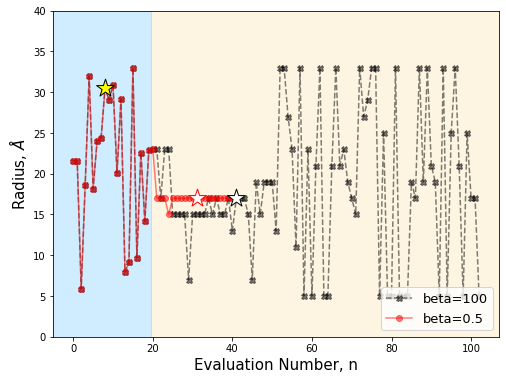

In [10]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

obj = 'radius'
y = df[obj]
y_2 = df_0p5[obj]
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Radius, $\AA$', fontsize = FontSize)

ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.show()


In [123]:
id_start = -2

yb1_mean = round(np.mean(df[id_start:]['yb_1']),4)
yb1_std = round(np.std(df[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df[id_start:]['er_1']),4)
er1_std = round(np.std(df[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df[id_start:]['yb_2']),4)
yb2_std = round(np.std(df[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df[id_start:]['er_2']),4)
er2_std = round(np.std(df[id_start:]['er_2']),4)
radius_mean = round(np.mean(df[id_start:]['radius']),4)
radius_std = round(np.std(df[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')


yb_1: 0.7639+/-0.01
er_1: 0.05+/-0.0003
yb_2: 0.0081+/-0.0
er_2: 0.0005+/-0.0
radius: 25.2486+/-0.17


In [121]:
id_start = -10

yb1_mean = round(np.mean(df_0p5[id_start:]['yb_1']),4)
yb1_std = round(np.std(df_0p5[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df_0p5[id_start:]['er_1']),4)
er1_std = round(np.std(df_0p5[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df_0p5[id_start:]['yb_2']),4)
yb2_std = round(np.std(df_0p5[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df_0p5[id_start:]['er_2']),4)
er2_std = round(np.std(df_0p5[id_start:]['er_2']),4)
radius_mean = round(np.mean(df_0p5[id_start:]['radius']),4)
radius_std = round(np.std(df_0p5[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')

yb_1: 0.6761+/-0.0119
er_1: 0.0197+/-0.0014
yb_2: 0.0355+/-0.0012
er_2: 0.0012+/-0.0001
radius: 25.4532+/-0.0523


In [ ]:


best_rec = df.iloc[10:].UV.idxmax()
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()


In [49]:
    df.iloc[best_rec]

yb_1              0.914359
er_1              0.024200
yb_2              0.000000
er_2              0.000000
radius           17.742771
UV             7231.248754
VIS            6874.998894
BLUE           1281.249799
GREEN          1349.999791
RED            2356.249622
TOTAL         14399.997621
ABSORPTION    47368.742281
qe                0.023702
Name: 217, dtype: float64

In [50]:
df_0p5.iloc[best_rec_2]


yb_1              0.648793
er_1              0.015075
yb_2              0.000026
er_2              0.000002
radius           22.349407
UV             8312.499205
VIS            8106.249223
BLUE           1493.749862
GREEN          1631.249830
RED            2662.499755
TOTAL         16862.498403
ABSORPTION    68674.993465
qe                0.019969
Name: 185, dtype: float64

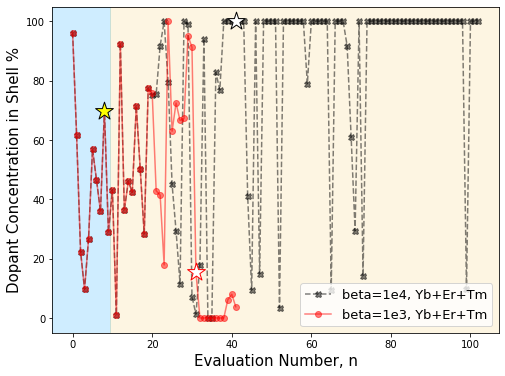

In [15]:
obj1 = 'yb_2'
obj2 = 'er_2'
obj3 = 'tm_2'
y = (df[obj1]+df[obj2]+df[obj3])*100
y_2 = (df_0p5[obj1]+df_0p5[obj2]+df_0p5[obj3])*100
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=1e4, Yb+Er+Tm')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=1e3, Yb+Er+Tm')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Dopant Concentration in Shell %', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.show()


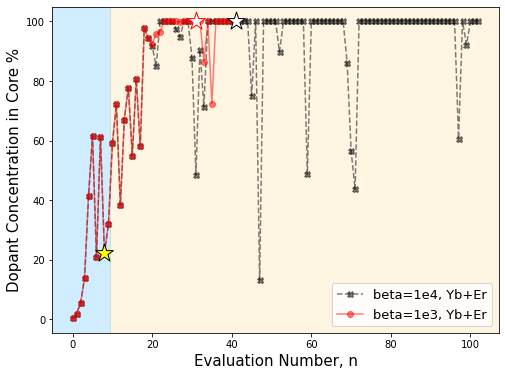

In [18]:
obj1 = 'yb_1'
obj2 = 'er_1'
obj3 = 'tm_1'
y = (df[obj1]+df[obj2]+df[obj3])*100
y_2 = (df_0p5[obj1]+df_0p5[obj2]+df_0p5[obj3])*100
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=1e4, Yb+Er')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=1e3, Yb+Er')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Dopant Concentration in Core %', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)

plt.show()

In [20]:
df.iloc[best_rec]

yb_1              0.182000
er_1              0.818000
tm_1              0.000000
yb_2              1.000000
er_2              0.000000
tm_2              0.000000
radius           17.000000
UV              524.999907
VIS            4043.749286
BLUE            262.499951
GREEN           881.249829
RED            2718.749538
TOTAL          4812.499154
ABSORPTION    32068.744325
qe                0.000872
Name: 41, dtype: float64

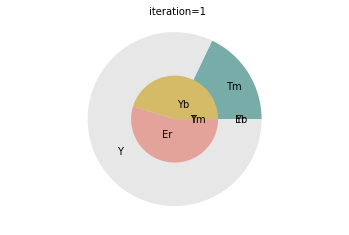

In [167]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
ax.axis('equal')
labels=["Yb", "Er", "Tm", "Y"]
# cm = plt.get_cmap("tab20")
# cmap = cm([2,5,0,15])
cm = colors.ListedColormap(['#D5BB67', '#E3A39A','#78ACA8', '#E7E7E7', '#20425B'])
cmap = cm([0,1,2,3,4])

temp = df_0p5.iloc[23]
yttrium1 = 1- temp.yb_1 - temp.er_1 - temp.tm_1
yttrium2 = 1- temp.yb_2 - temp.er_2 - temp.tm_2
pie_shell, _ = ax.pie([temp.yb_2,temp.er_2,temp.tm_2, round(yttrium2,3)], radius=1, labels=labels, labeldistance = 0.7,colors = cmap)
pie_core, _ = ax.pie([temp.yb_1,temp.er_1,temp.tm_1, round(yttrium1,3)], radius =temp.radius/34, labels=labels, labeldistance=0.7*temp.radius/34,colors = cmap)
# plt.setp(pie_core,edgecolor='white')
# plt.setp(pie_shell,edgecolor='white')
plt.text(-0.3,1.2,'iteration='+str(i-19))
plt.show()

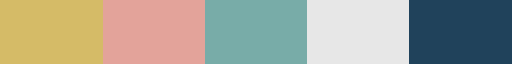

In [145]:
cm

In [178]:
import matplotlib.colors as colors
def showNP_nolabel(temp):   
    fig, ax = plt.subplots()
    ax.axis('equal')
    labels=["Yb", "Er", "Tm", "Y"]
    cm = colors.ListedColormap(['#D5BB67', '#E3A39A','#78ACA8', '#E7E7E7','#20425B'])
    cmap = cm([0,1,2,3,4])

    yttrium1 = 1- temp.yb_1 - temp.er_1 - temp.tm_1
    yttrium2 = 1- temp.yb_2 - temp.er_2 - temp.tm_2
    pie_surface, _ = ax.pie([0, 0, 0, 0,1], radius=40/34, colors = cmap)
    pie_shell, _ = ax.pie([temp.yb_2,temp.er_2,temp.tm_2, round(yttrium2,3),0], radius=1, colors = cmap)
    pie_core, _ = ax.pie([temp.yb_1,temp.er_1,temp.tm_1, round(yttrium1,3),0], radius =temp.radius/34, colors = cmap)
    plt.setp(pie_core,edgecolor='white')
    plt.setp(pie_shell,edgecolor='white')
    plt.show()
def showNP(temp, i):   
    fig, ax = plt.subplots()
    ax.axis('equal')
    labels=["Yb", "Er", "Tm", "Y"]
    cm = colors.ListedColormap(['#D5BB67', '#E3A39A','#78ACA8', '#E7E7E7','#20425B'])
    cmap = cm([0,1,2,3,4])

    yttrium1 = 1- temp.yb_1 - temp.er_1 - temp.tm_1
    yttrium2 = 1- temp.yb_2 - temp.er_2 - temp.tm_2
    pie_surface, _ = ax.pie([0, 0, 0, 0,1], radius=40/34, colors = cmap)
    pie_shell, _ = ax.pie([temp.yb_2,temp.er_2,temp.tm_2, round(yttrium2,3),0], radius=1, colors = cmap)
    pie_core, _ = ax.pie([temp.yb_1,temp.er_1,temp.tm_1, round(yttrium1,3),0], radius =temp.radius/34, colors = cmap)
    plt.setp(pie_core,edgecolor='white')
    plt.setp(pie_shell,edgecolor='white')
    plt.text(-0.3,1.2,'iteration='+str(i))


    plt.show()
    return fig

In [190]:
idxs = df_0p5.VIS.nlargest(5).index
for i in idxs:
    print(i)

31
25
26
40
36


In [191]:
df_0p5.iloc[40:47]

,yb_1,er_1,tm_1,yb_2,er_2,tm_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
40,0.454,0.513,0.033,0.08,0.0,0.000,17.0,731.248710,4499.992861,199.999728,993.748337,3118.745084,5649.990765,8081.237028,0.007052
41,0.461,0.539,0.000,0.00,0.0,0.038,17.0,624.998858,3781.242206,243.749485,887.498191,2493.744849,4693.740494,3806.242861,0.011779


31
6262.492775


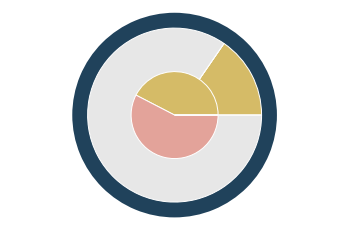

25
4999.996938


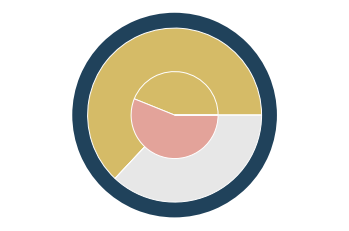

26
4512.498874


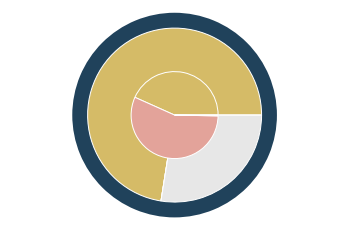

40
4499.992861


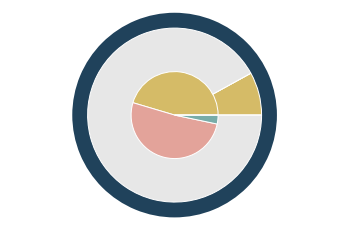

36
4468.740611


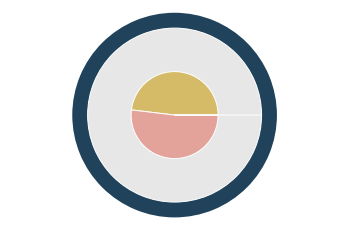

In [192]:
for i in idxs:
    print(i)
    print(df_0p5.iloc[i].VIS)
    fig=showNP_nolabel(df_0p5.iloc[i])

20


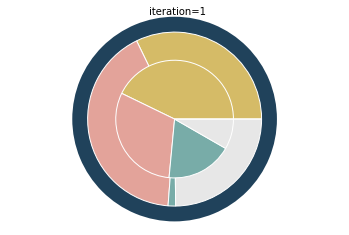

21


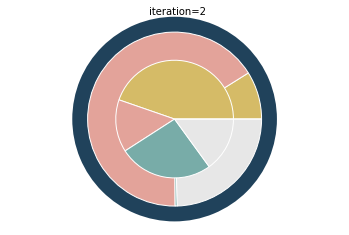

22


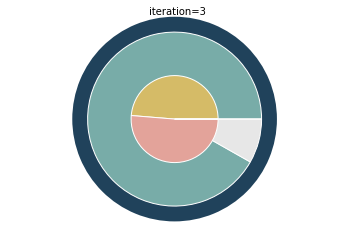

23


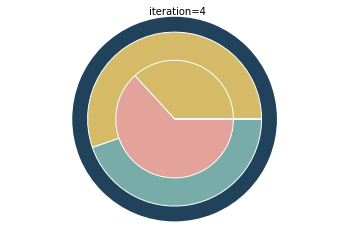

24


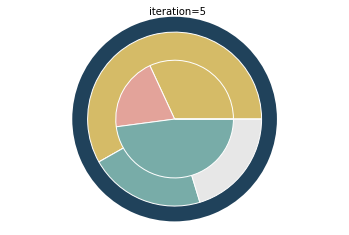

25


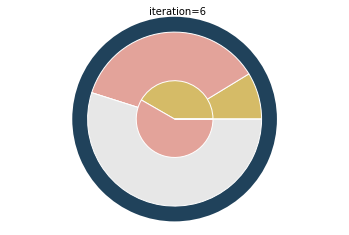

26


/var/folders/1p/p3nt7c517n924qqsrxjsgt240000gn/T/ipykernel_82227/568504560.py:13: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  pie_core, _ = ax.pie([temp.yb_1,temp.er_1,temp.tm_1, round(yttrium1,3),0], radius =temp.radius/34, colors = cmap)


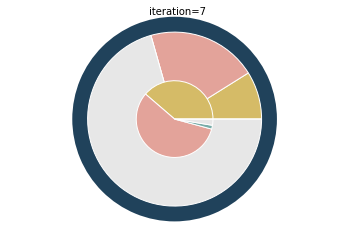

27


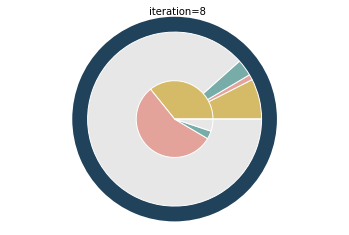

28


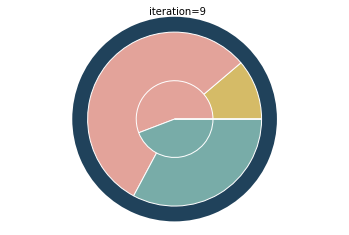

29


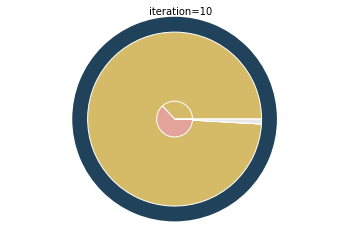

30


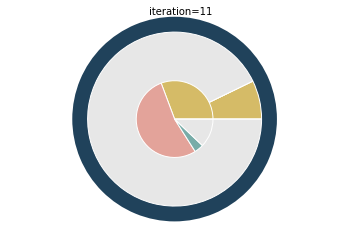

31


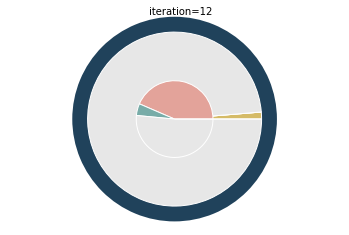

32


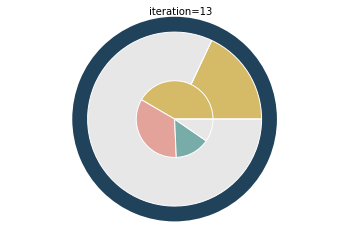

33


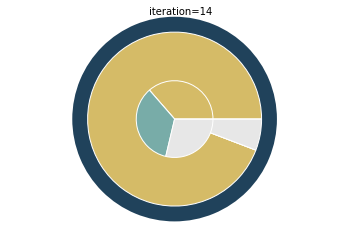

34


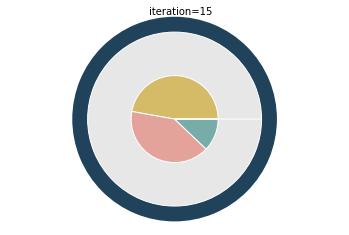

35


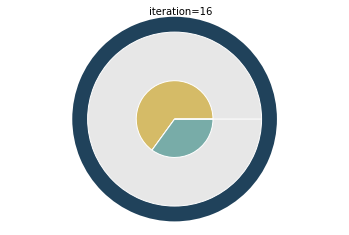

36


/var/folders/1p/p3nt7c517n924qqsrxjsgt240000gn/T/ipykernel_82227/568504560.py:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  pie_shell, _ = ax.pie([temp.yb_2,temp.er_2,temp.tm_2, round(yttrium2,3),0], radius=1, colors = cmap)


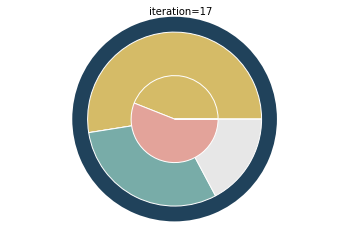

37


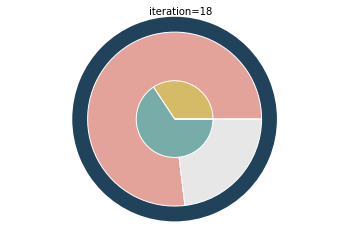

38


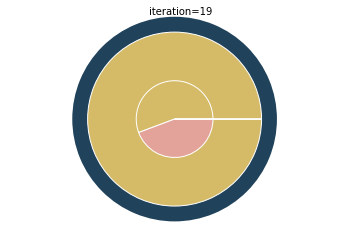

39


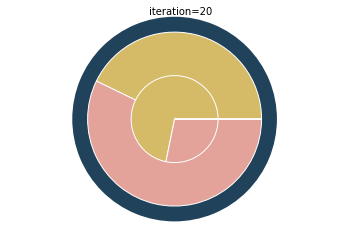

40


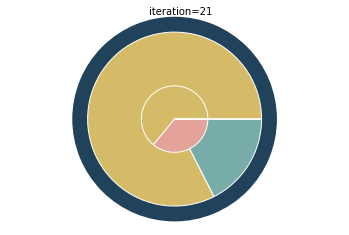

41


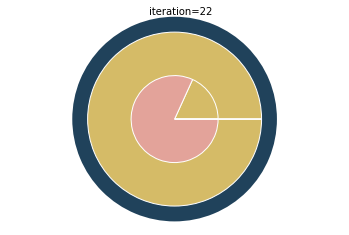

42


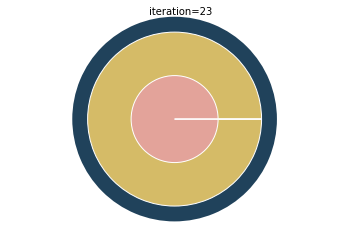

43


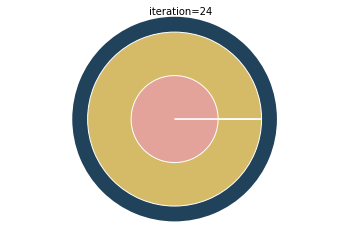

44


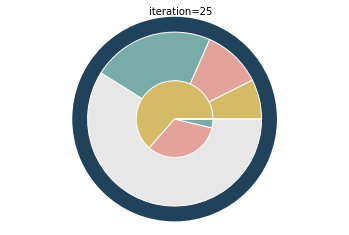

45


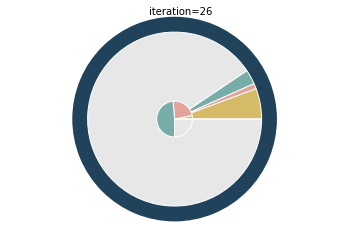

46


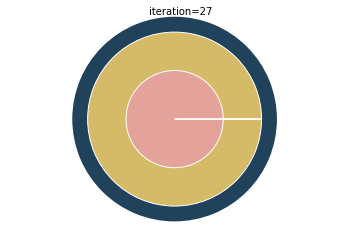

47


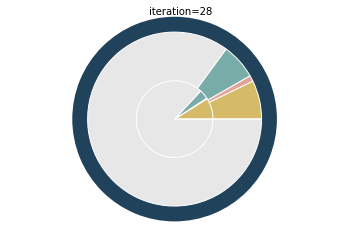

48


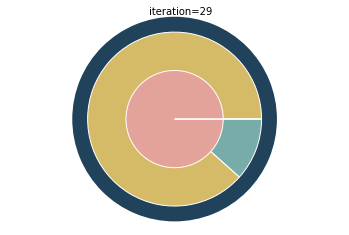

49


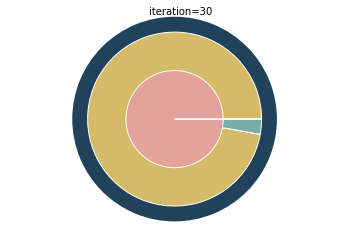

50


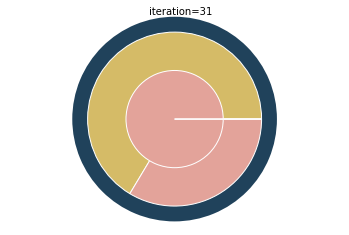

51


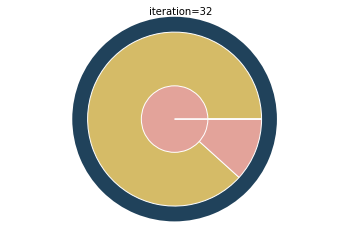

52


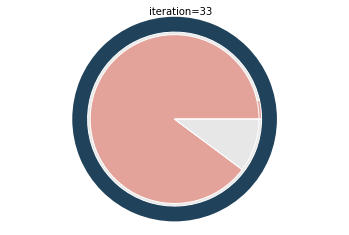

53


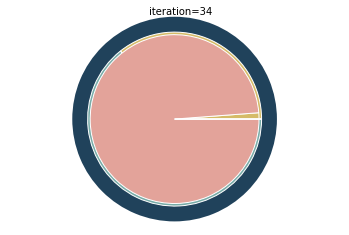

54


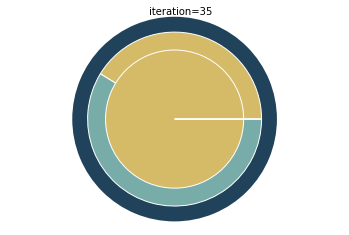

55


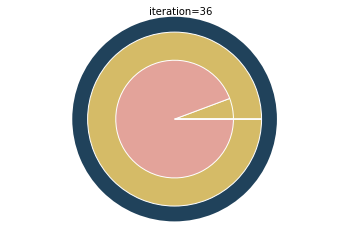

56


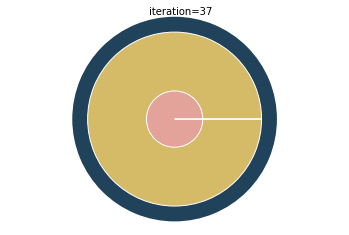

57


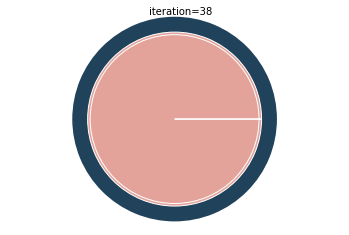

58


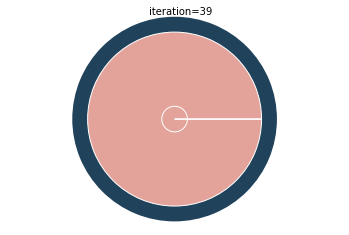

59


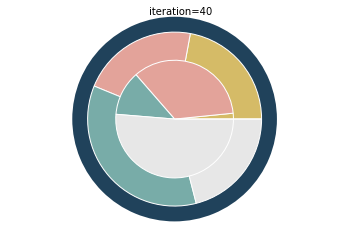

60


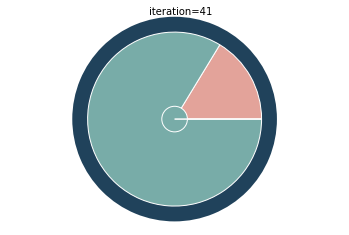

61


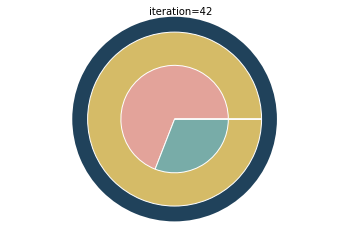

62


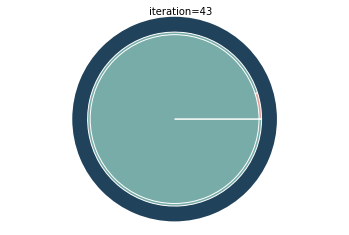

63


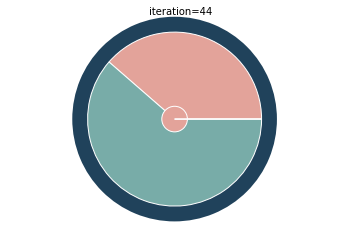

64


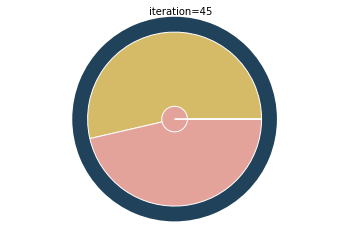

65


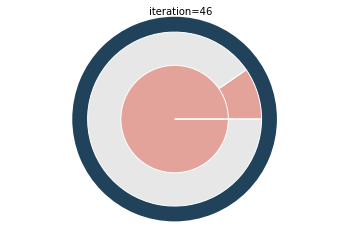

66


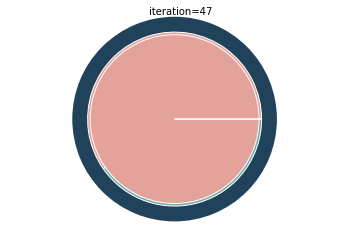

67


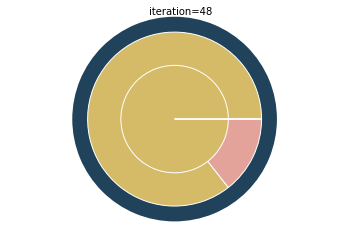

68


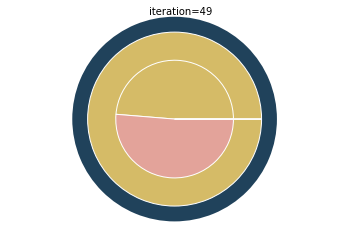

69


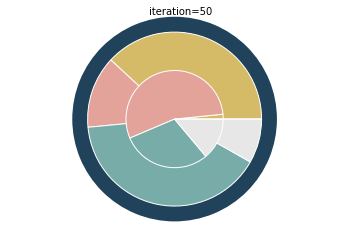

70


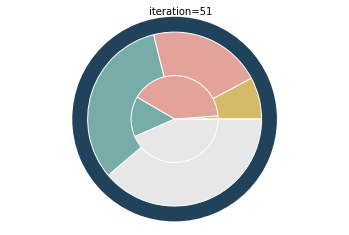

71


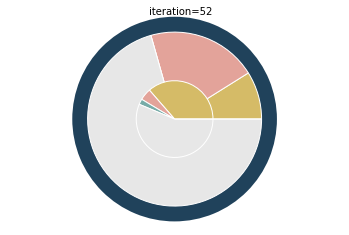

72


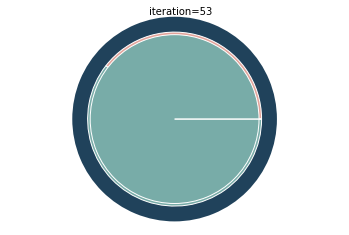

73


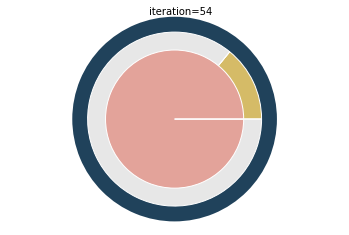

74


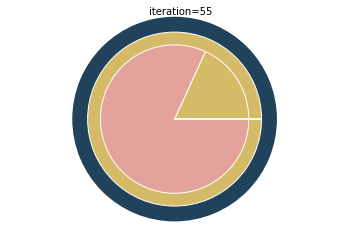

75


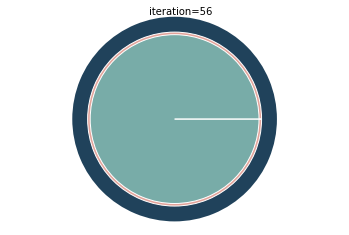

76


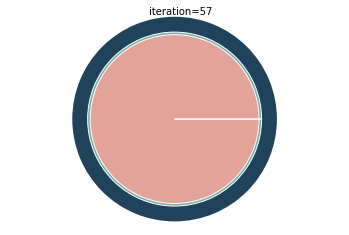

77


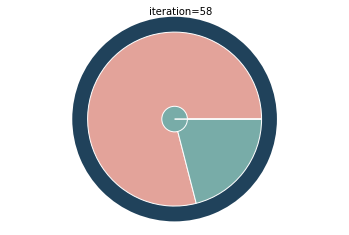

78


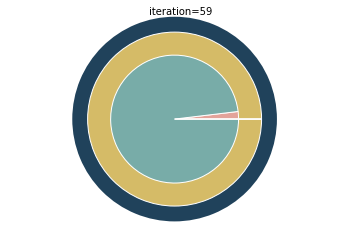

79


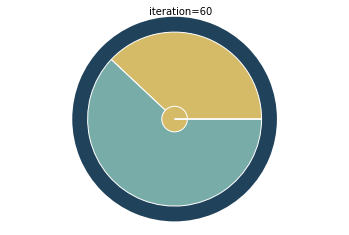

80


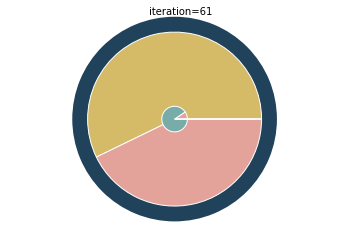

81


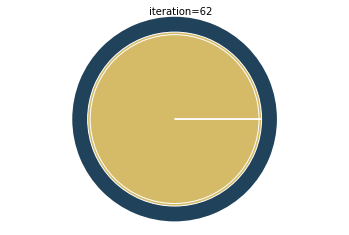

82


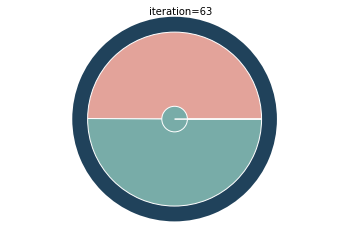

83


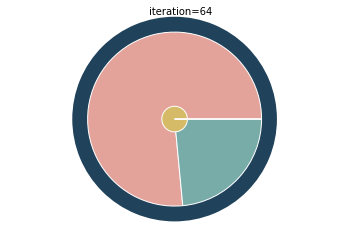

84


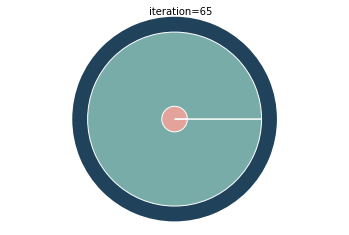

85


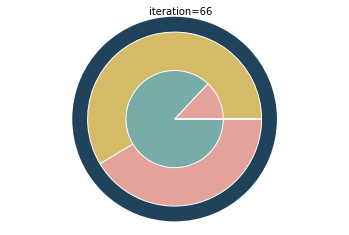

86


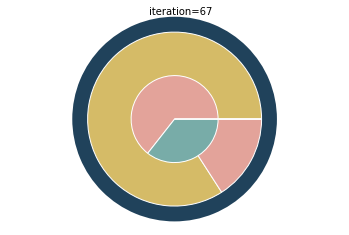

87


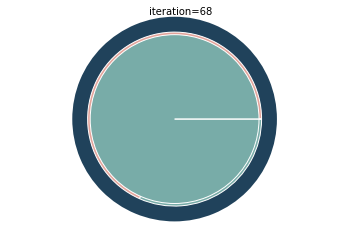

88


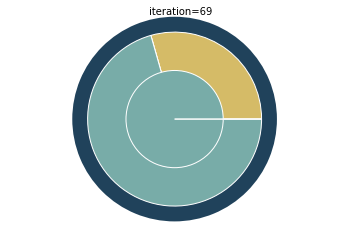

89


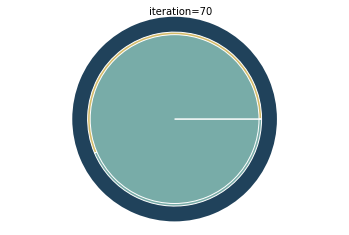

90


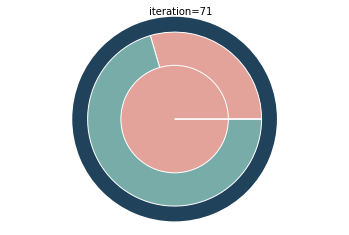

91


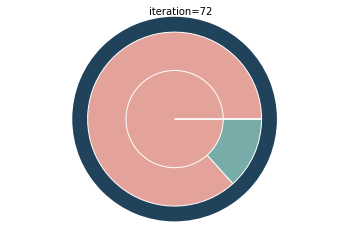

92


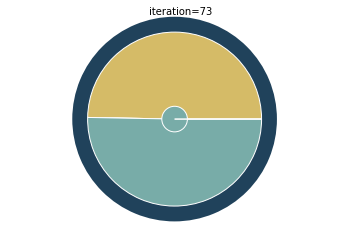

93


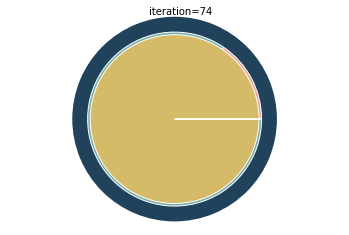

94


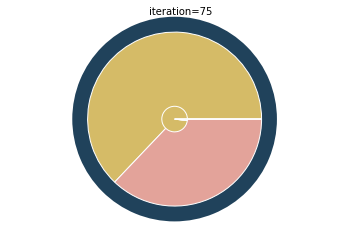

95


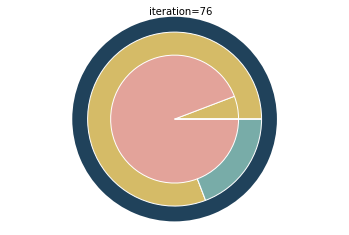

96


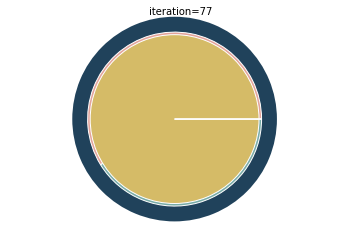

97


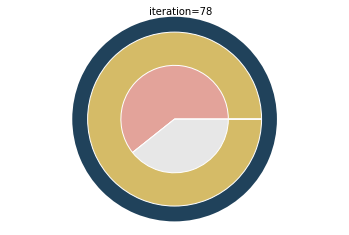

98


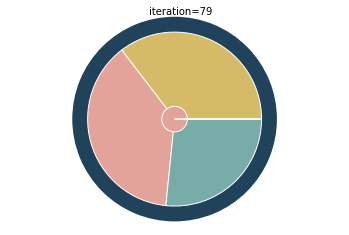

99


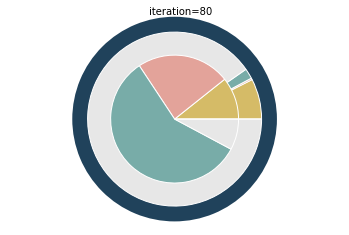

100


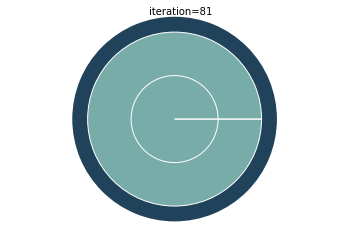

101


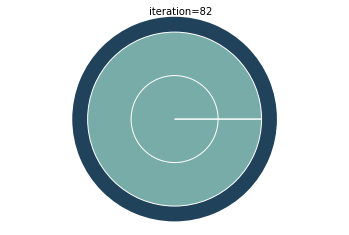

In [174]:
itr=0
for i in range(20,102):
    print(i)
    itr+=1
    fig=showNP(df.iloc[i],itr)
    fname = 'images/1e4_'+str(i)+'.png'
    fig.savefig(fname)

In [176]:
import imageio
images = []
for i in range(20,102):
    filename = 'images/1e4_'+str(i)+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave('images/1e4_evolve.gif', images, duration = 0.5)

# PCA

In [196]:
from sklearn.decomposition import PCA
import pandas as pd
# Load samples for demonstration
DATA_DEST1 = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df = pd.concat([df1,df2.iloc[20:]],ignore_index=True)
X = df[['yb_1','er_1','tm_1','yb_2','er_2','tm_2','radius']].to_numpy()
# Standardized features for PCA
autoscaled_X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
autoscaled_X


array([[-8.53288072e-01, -1.17721257e+00, -6.00247776e-01,
        -4.90526518e-01,  7.73338525e-01,  9.55842087e-01,
         3.58960250e-01],
       [-8.46501156e-01, -1.14600644e+00, -5.95879120e-01,
         4.79002288e-02, -3.79119152e-01,  1.41533631e-01,
         3.50705236e-01],
       [-8.36790164e-01, -1.17713948e+00, -4.64586648e-01,
        -8.06896571e-01, -1.88139072e-01, -3.96263093e-01,
        -1.59168081e+00],
       [-8.16119973e-01, -1.10422396e+00, -3.07487362e-01,
        -7.81695601e-01, -6.78837363e-01, -3.94910359e-01,
        -1.49903615e-02],
       [-8.14075554e-01, -5.18954375e-01, -1.03980554e-01,
        -5.43927972e-01, -6.29481381e-01, -1.31390906e-01,
         1.64772520e+00],
       [-7.82713884e-01, -2.88616578e-01,  2.29624525e-01,
        -4.02338569e-01, -6.02945558e-01,  7.95300015e-01,
        -6.95251264e-02],
       [-7.76271181e-01, -7.71485072e-01, -4.86230390e-01,
        -2.25659350e-01, -1.74955853e-01, -2.76536675e-01,
         6.6244185

[0.27981552 0.18577924 0.15862061 0.14173106]
0.7659464279154018


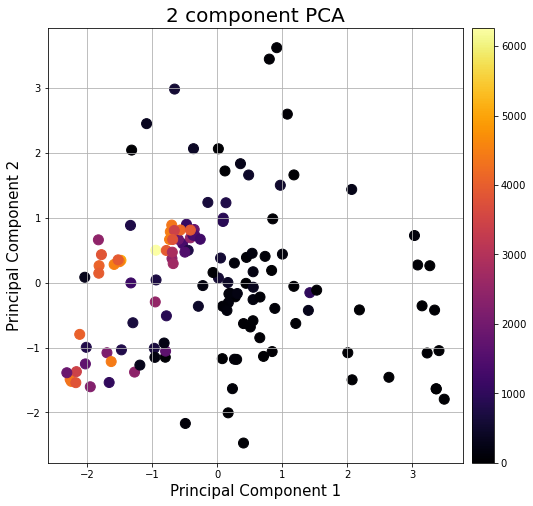

In [216]:
# Two-component PCA
from matplotlib import cm
import matplotlib.pyplot as plt


pca = PCA(n_components=4)
principalComponents = pca.fit_transform(autoscaled_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

#Link UV intensity to priciple components 
finalDf = pd.concat([principalDf, df[['VIS']]], axis = 1)

cmap = cm.get_cmap('inferno')
my_color=finalDf['VIS']
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
p=ax.scatter(finalDf['principal component 1']
               , finalDf['principal component 2'], c=my_color, cmap=cmap, s=100)
ax.grid()
plt.colorbar(p, ax=ax, fraction=0.05, pad=0.02)
# Print explained values

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

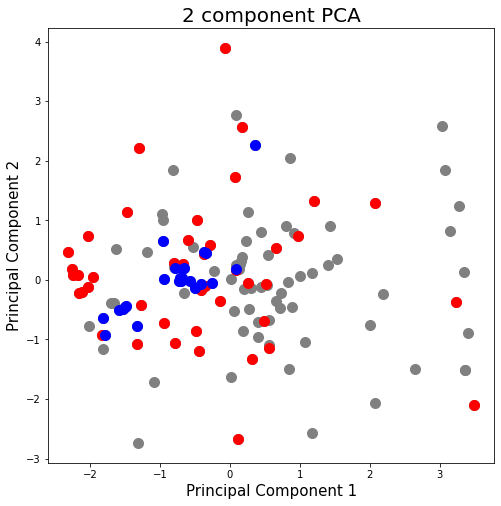

In [211]:
inital = finalDf[:20]
beta1 = finalDf[20:20+len(df2)]
beta2 = finalDf[len(df1):]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
p=ax.scatter(finalDf['principal component 1']
               , finalDf['principal component 3'], c='gray', s=100)
p=ax.scatter(beta1['principal component 1']
               , beta1['principal component 3'], c='red', s=100)
p=ax.scatter(beta2['principal component 1']
               , beta2['principal component 3'], c='b', s=100)
#ax.grid()
